In [1]:
!pip install numpy
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install unsloth
!pip install -U transformers

Looking in indexes: https://download.pytorch.org/whl/cu128
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 GB 1.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.6/609.6 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 106.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 19.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.9/726.9 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [3]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRITON_DISABLE_AUTOTUNE"] = "1"
os.environ["TRITON_DISABLE_LINE_INFO"] = "1"
os.environ["USE_CUT_CROSS_ENTROPY"] = "0"
os.environ["UNSLOTH_DISABLE_FAST_LOSS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Force single GPU

from unsloth import FastLanguageModel
from datasets import load_dataset
from transformers import TrainingArguments
from trl import SFTTrainer

# 1. Load and preprocess dataset
url = "https://huggingface.co/datasets/gbharti/finance-alpaca/resolve/main/Cleaned_date.json"
dataset = load_dataset("json", data_files={"train": url}, split="train")

def format_alpaca(example):
    return {
        "text": f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{example['instruction']} {example['input']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{example['output']}<|eot_id|>"
    }

dataset = dataset.map(format_alpaca)
dataset = dataset.select(range(3000))  #using 3k samples

# 2. Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = 2048,
    load_in_4bit = True,
    device_map = "auto",
)

# 3. Test before training
def generate_text(text):
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

print("Before training")
generate_text("<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nwhat is quant?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-12 06:03:48.890268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752300229.247482      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752300229.358647      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

Cleaned_date.json:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/68912 [00:00<?, ? examples/s]

==((====))==  Unsloth 2025.7.3: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Before training
user

what is quant?assistant

quantum mechanics is a branch of physics that studies the behavior of matter and energy at the atomic and subatomic level. it is the foundation of all of modern physics, and it is the most accurate of all the natural sciences. quantum mechanics explains phenomena


In [4]:
from transformers import EarlyStoppingCallback

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 3407,
    max_seq_length = 2048,
    use_rslora = False,
    loftq_config = None,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=2048,
    args=TrainingArguments(
        output_dir="outputs",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=2,
        learning_rate=2e-4,
        bf16=False,
        fp16=True,
        logging_steps=10,
        save_steps=200,
        eval_strategy="steps",
        eval_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        remove_unused_columns=False,
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # stops if no improvement after 2 evals
    eval_dataset=dataset.select(range(500)),  # Optional: small subset for eval
)

trainer.train()
print("After training")
generate_text("<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nwhat is quant?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n")

Unsloth 2025.7.3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Tokenizing ["text"]:   0%|          | 0/3000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/500 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 2 | Total steps = 1,500
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
200,2.521600,2.485991
400,2.452300,2.411805
600,2.494900,2.361380
800,2.211300,2.277125
1000,2.171200,2.174860
1200,2.217300,2.112003
1400,2.182500,2.069464


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for inst

After training
user

what is quant?assistant

Quantitative analysis is the application of mathematical and statistical methods to financial data.  A quant is someone who does quantitative analysis.  A quant job is a job that involves quantitative analysis.  A quant fund is a fund that uses quantitative analysis. 


In [11]:
generate_text("<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhats the importance of quant?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


user

Whats the importance of quant?assistant

Quantitative finance is a field of finance that uses mathematical and statistical methods to analyze and manage financial risks. It is a relatively new field that has emerged in the last few decades as the financial industry has become more complex and globalized. Quantitative finance


In [6]:
import json
with open("eval_metrics.json", "w") as f:
    json.dump(trainer.state.log_history, f, indent=2)

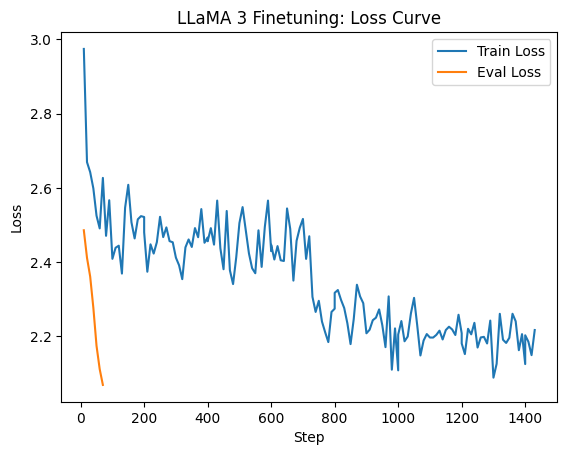

In [7]:
import json
import matplotlib.pyplot as plt
import os

# Create the folder if it doesn't exist
os.makedirs("training", exist_ok=True)

# Load metrics
with open("eval_metrics.json") as f:
    data = json.load(f)

steps, train_loss, eval_loss = [], [], []

for row in data:
    if 'step' in row:
        steps.append(row['step'])
    if 'loss' in row:
        train_loss.append(row['loss'])
    if 'eval_loss' in row:
        eval_loss.append(row['eval_loss'])

# Plot
plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("LLaMA 3 Finetuning: Loss Curve")
plt.legend()
plt.savefig("loss_plot.png")


In [ ]:
model.push_to_hub(
    "YOUR_HUGGINGFACE_USERNAME/finllama-lora",
    tokenizer,
    save_method="lora",
    token="YOUR_HUGGINGFACE_TOKEN",  # replace with your Hugging Face token
)

#for using the tuned model apply the adapter
from unsloth import FastLanguageModel

# Load base model (same one used)
base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",  # base model used
    max_seq_length = 2048,
    load_in_4bit = True,
    device_map = "auto",
)

# Load your adapter
base_model.load_adapter("YOUR_HUGGINGFACE_USERNAME/finllama-lora")  #pushed LoRA repo
text = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nwhats the future of quant finance?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
inputs = tokenizer(text, return_tensors="pt").to(base_model.device)
outputs = base_model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0]))


README.md:   0%|          | 0.00/575 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/kenzi123/finllama-lora
==((====))==  Unsloth 2025.7.3: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

whats the future of quant finance?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Quantitative finance is a very broad field.  There are many different types of jobs and career paths within the field.  It's a very good idea to be aware of the different types of jobs and career paths and to be prepared for the possibility that you may not end up doing exactly what you think you will.  There are many people who have gotten into quantitative finance because of a strong interest in math, statistics, and computer science and then found themselves working in completely different areas of the field
